 # Leukemia using ATSC

In [33]:
library("binom") 
library("evaluomeR")
library("clusterAnalysis")
library("dplyr")
library("caret")
library("ggplot2")
library("ggrepel")
library("reshape2")
library("mclust")

options(scipen=10)
options(repr.plot.width=12, repr.plot.height=12)

In [34]:
getRversion()
packageVersion("clusterAnalysis")

[1] '4.4.1'

[1] '0.0.0.9000'

# Dataset <a class="anchor" id="dataset"></a>

In [35]:
load("TCGAData200.RData")
dataset=TCGAData200
dataset$Description = TCGAData200$PAM50
dataset$PAM50 = NULL
set.seed(13626)
head(dataset)

,Description,LTF,NPY1R,PGR,RPS28,SFRP1,PLIN4,S100P,PDZK1,C16orf89,⋯,MMP9,SH3RF2,PADI2,GPAT2,PDE3B,FGFR3,GALNT14,CYP21A2,WISP2,PDE8B
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
TCGA-A1-A0SD-01,Luminal A,11.978259,12.778363,9.485349,8.201800,10.709060,10.383206,9.647907,7.358335,5.3110271,⋯,9.400612,6.919838,8.805018,5.132059,6.726067,10.147290,7.240188,8.270969,7.065917,8.211493
TCGA-A1-A0SE-01,Luminal A,12.779078,8.741927,12.807370,3.644445,13.078639,6.667984,5.943417,9.736929,5.7540751,⋯,6.754074,7.920084,10.368784,4.350716,5.254503,9.319850,5.339038,7.419833,8.312402,6.309411
TCGA-A1-A0SH-01,Luminal A,11.231554,5.948533,12.176581,8.229385,11.346664,5.115645,6.905720,2.115633,0.8526381,⋯,9.890979,5.769084,9.537708,6.394867,5.054241,4.145392,4.085272,4.433721,10.229385,7.410264
TCGA-A1-A0SJ-01,Luminal A,7.804147,9.461259,11.884642,4.163829,10.991285,11.145075,9.916533,8.783936,5.8437402,⋯,9.078549,5.040971,7.239116,6.064818,8.942509,8.637907,6.080500,8.568362,10.756743,6.263365
TCGA-A1-A0SK-01,Basal-like,4.089040,5.483900,2.793584,9.945638,12.763559,1.141498,4.141506,3.463439,4.4634328,⋯,9.403602,2.582074,11.992810,1.656084,8.225936,8.133434,10.766694,1.809250,2.978013,5.154332
TCGA-A1-A0SM-01,Luminal B,7.826276,4.526250,6.455368,9.440371,8.159795,3.336426,11.191101,7.383551,1.5063480,⋯,9.542832,7.889097,9.475339,5.565247,4.762694,6.574833,4.584355,10.308822,9.321558,4.693978


In [36]:
level_mapping <- c("Luminal A" = 1, "Basal-like" = 2, "Luminal B" = 3, "HER2-enriched" = 4, "Normal-like" = 5)
map_strings_to_numbers <- function(strings) {
  factorized <- factor(strings, levels = names(level_mapping))
  as.numeric(factorized)
}
gold_standard_vector = as.vector(unlist(lapply(dataset["Description"], map_strings_to_numbers)))
gold_standard_vector

[1] 1 1 1 1 2 3 2 1 2 2 3 2 2 1 4 4 1 4 2 1 1 1 3 1 1 3 4 4 1 2 4 2 1 3 1 1 1
 [38] 4 3 1 1 1 1 1 1 3 2 1 3 3 2 1 2 4 2 3 3 1 1 1 1 1 2 1 3 3 1 2 5 1 2 1 2 2
 [75] 1 1 1 3 1 1 2 1 1 2 2 2 3 3 3 3 1 3 3 1 1 3 1 3 4 4 3 4 2 1 1 1 4 1 3 2 1
[112] 2 3 2 3 3 4 3 1 3 3 1 1 4 1 3 3 2 3 4 4 1 3 2 1 4 1 1 1 4 1 4 3 3 3 1 1 1
[149] 3 3 4 3 3 3 3 3 1 1 3 4 3 1 1 1 1 4 3 3 1 1 3 3 1 3 1 4 2 3 3 2 3 2 3 2 1
[186] 3 2 3 2 1 1 1 4 1 2 3 1 2 1 1 1 1 3 1 1 2 1 3 4 1 4 3 3 5 5 5 1 4 3 2 2 3
[223] 1 1 1 5 3 3 4 1 1 3 1 2 3 2 1 1 2 2 1 3 1 4 1 2 1 1 3 2 1 2 3 1 2 3 2 3 1
[260] 4 3 3 2 3 3 2 2 2 2 1 1 1 5 1 2 2 1 4 1 3 1 1 2 2 1 2 1 4 1 3 3 5 1 1 2 4
[297] 3 1 1 1 2 2 1 4 1 3 1 1 1 1 1 4 2 2 1 1 1 3 3 2 1 1 1 2 1 3 1 3 3 2 4 3 3
[334] 1 1 1 1 2 2 1 3 3 4 4 1 1 2 1 1 1 1 3 3 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1
[371] 2 2 3 3 3 3 1 3 3 3 3 3 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 4 4 2 2 1
[408] 1 1 2 1 1 1 1 4 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 3 3 1 4 2
[445] 3 1 1 1 2 3 2 1 1 3 3 2 2 3 3 1 1 1 1 4 4 2 2 4 4 1 1 1 3 3 2 2 2 1 1 1 1
[482] 1 1 1 1 4 4 3 3 2 2 2 4 3 1 1 4 4 4 3 2 3 3 1 4 4 2 1 1 2 4 4 4 4 3 1 3 3
[519] 3 3 4 3 1 2 2 1 2 1 1 3 5 3 3 1 3 1 1 2 3 4 1 2 3 1 4 3 2 2 1 2 4 1 1 1 3
[556] 1 2 2 2 3 3 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 1 1 1 3 3 2 4 1 1 2 1 1 1 1

# Clest <a class="anchor" id="clest"></a>
Execution of Clest over the previous dataset.

In [37]:
dataset_matrix = as.matrix(dataset[, -1])
clest_result = clusterAnalysis::clest(dataset_matrix, maxK=10, pmax=0.05, dmin=0.05, B=20,B0=20,
                                  clusterAlg=myPam, rho=2/3, similarity=dendextend::FM_index_R, verbose=FALSE)
message(paste0("Clest optimal k: ", clest_result$kopt))

Clest optimal k: 3



In [38]:
pa = cluster::pam(dataset_matrix, clest_result$kopt)
predicted = pa$clustering

In [39]:
dataset["Cluster"] = as.factor(as.numeric(predicted))
pca_matrix = dataset %>% select(-Cluster)
r_pca = evaluomeR::performPCA(dataset = pca_matrix)
pca_df = r_pca$dataset_ncp
pca_df$Cluster <- as.factor(dataset$Cluster)
pca_df$Description <- dataset$Description

Parameter 'npc' is null. Computing number of factors automatically:

Number of factors, 'ncp' used is: 33



In [40]:
# Creating shapes for individuals
pca_df <- pca_df %>%
  mutate(
    # Extract the letter from the Description column
    Letter = Description,
    # Map the letter to a number
    GoldStandard = case_when(
      Letter == "Luminal A" ~ 16,
      Letter == "Basal-like" ~ 17,
      Letter == "Luminal B" ~ 18,
      Letter == "HER2-enriched" ~ 21,
      Letter == "Normal-like" ~ 22, 
      TRUE ~ NA_real_  # Else...
    )
  )
pca_df$GoldStandard = as.factor(pca_df$GoldStandard)

Warning message:
"The following aesthetics were dropped during statistical transformation: shape
and label.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?"
Warning message:
"ggrepel: 587 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


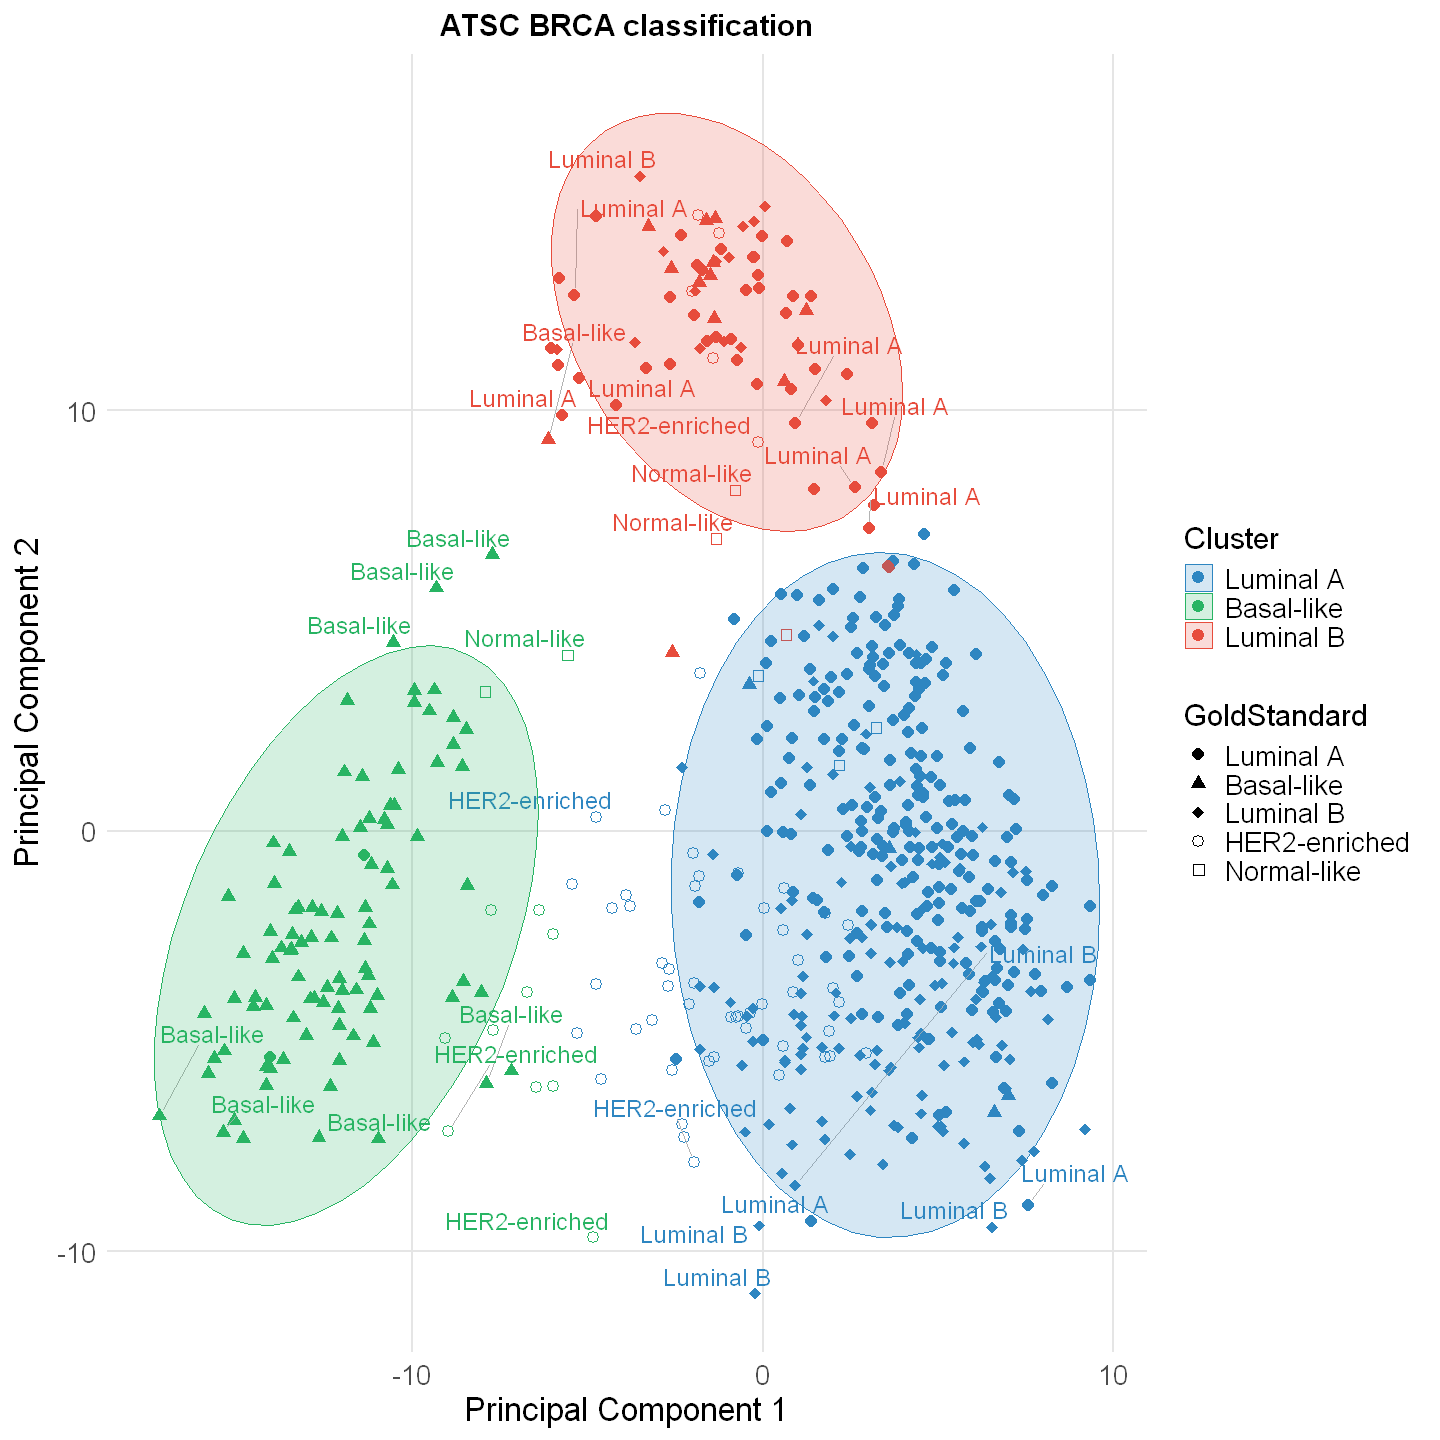

In [41]:
cluster_colors = c("#2E86C1", "#28B463", "#E74C3C", "#9B59B6", "#F1C40F", "#7F8C8D")

cluster_shapes = c(16, 17, 18, 21, 22)
cluster_labels = c("Luminal A", "Basal-like", "Luminal B", "HER2-enriched", "Normal-like")

ggplot(pca_df, aes(x = Dim.1, y = Dim.2, shape = GoldStandard, color = Cluster, label = Description)) +
  geom_point(size = 3) +
  geom_text_repel(
    vjust = 1,
    hjust = 1,
    size = 5,
    show.legend = FALSE,
    point.padding = 0.4,
    box.padding = 0.25,
    max.overlaps = 5,
    segment.color = "grey70",
    segment.size = 0.2
  ) +
  stat_ellipse(aes(fill = Cluster, group = Cluster), level = 0.95, alpha = 0.2, geom = "polygon") +
  labs(
    title = "ATSC BRCA classification",
    x = "Principal Component 1",
    y = "Principal Component 2"
  ) +
  scale_shape_manual(values = cluster_shapes, labels = unique(pca_df$Description)) +
  scale_color_manual(values = cluster_colors, labels = cluster_labels)  +
  scale_fill_manual(values = cluster_colors, labels = cluster_labels)   +
  theme_minimal(base_size = 15) +
  theme(
    plot.title = element_text(hjust = 0.5, size = 18, face = "bold"),
    axis.title.x = element_text(size = 20),
    axis.title.y = element_text(size = 20),
    axis.text = element_text(size = 16),
    legend.position = "right",
    legend.title = element_text(size = 18),
    legend.text = element_text(size = 16),
    panel.grid.major = element_line(color = "grey90"),
    panel.grid.minor = element_blank()
  )

In [42]:
pa = cluster::pam(dataset_matrix, 4)
predicted = as.numeric(pa$clustering)

In [43]:
sen = RSKC::Sensitivity(predicted, gold_standard_vector)
sensitivity_table <- sen$prob[1,]
names(sensitivity_table) = names(level_mapping[!grepl("K56|MCF", names(level_mapping))])
sensitivity_table
paste0("(", paste(unlist(sensitivity_table), collapse = ","), ")")

,Luminal A,Basal-like,Luminal B,HER2-enriched,Normal-like
,<chr>,<chr>,<chr>,<chr>,<chr>
Sensitivity. (%),51,85,64,73,62


[1] "(51,85,64,73,62)"

In [44]:
cer = CER(predicted, gold_standard_vector)
cer = format(round(cer*100, 2), nsmall = 2)
print(paste0("CER: ", cer, "%"))

[1] "CER: 32.77%"


In [45]:
clest_result

$p
[1] 0 0 0 0 0 0 0 0 0

$d
[1] 0.2031519 0.4986828 0.2649120 0.2062387 0.1943974 0.2168731 0.2151700
[8] 0.2158758 0.2011652

$kopt
[1] 3

Warning message:
"Removed 1 row containing missing values or values outside the scale range
(`geom_line()`)."
Warning message:
"Removed 1 row containing missing values or values outside the scale range
(`geom_point()`)."


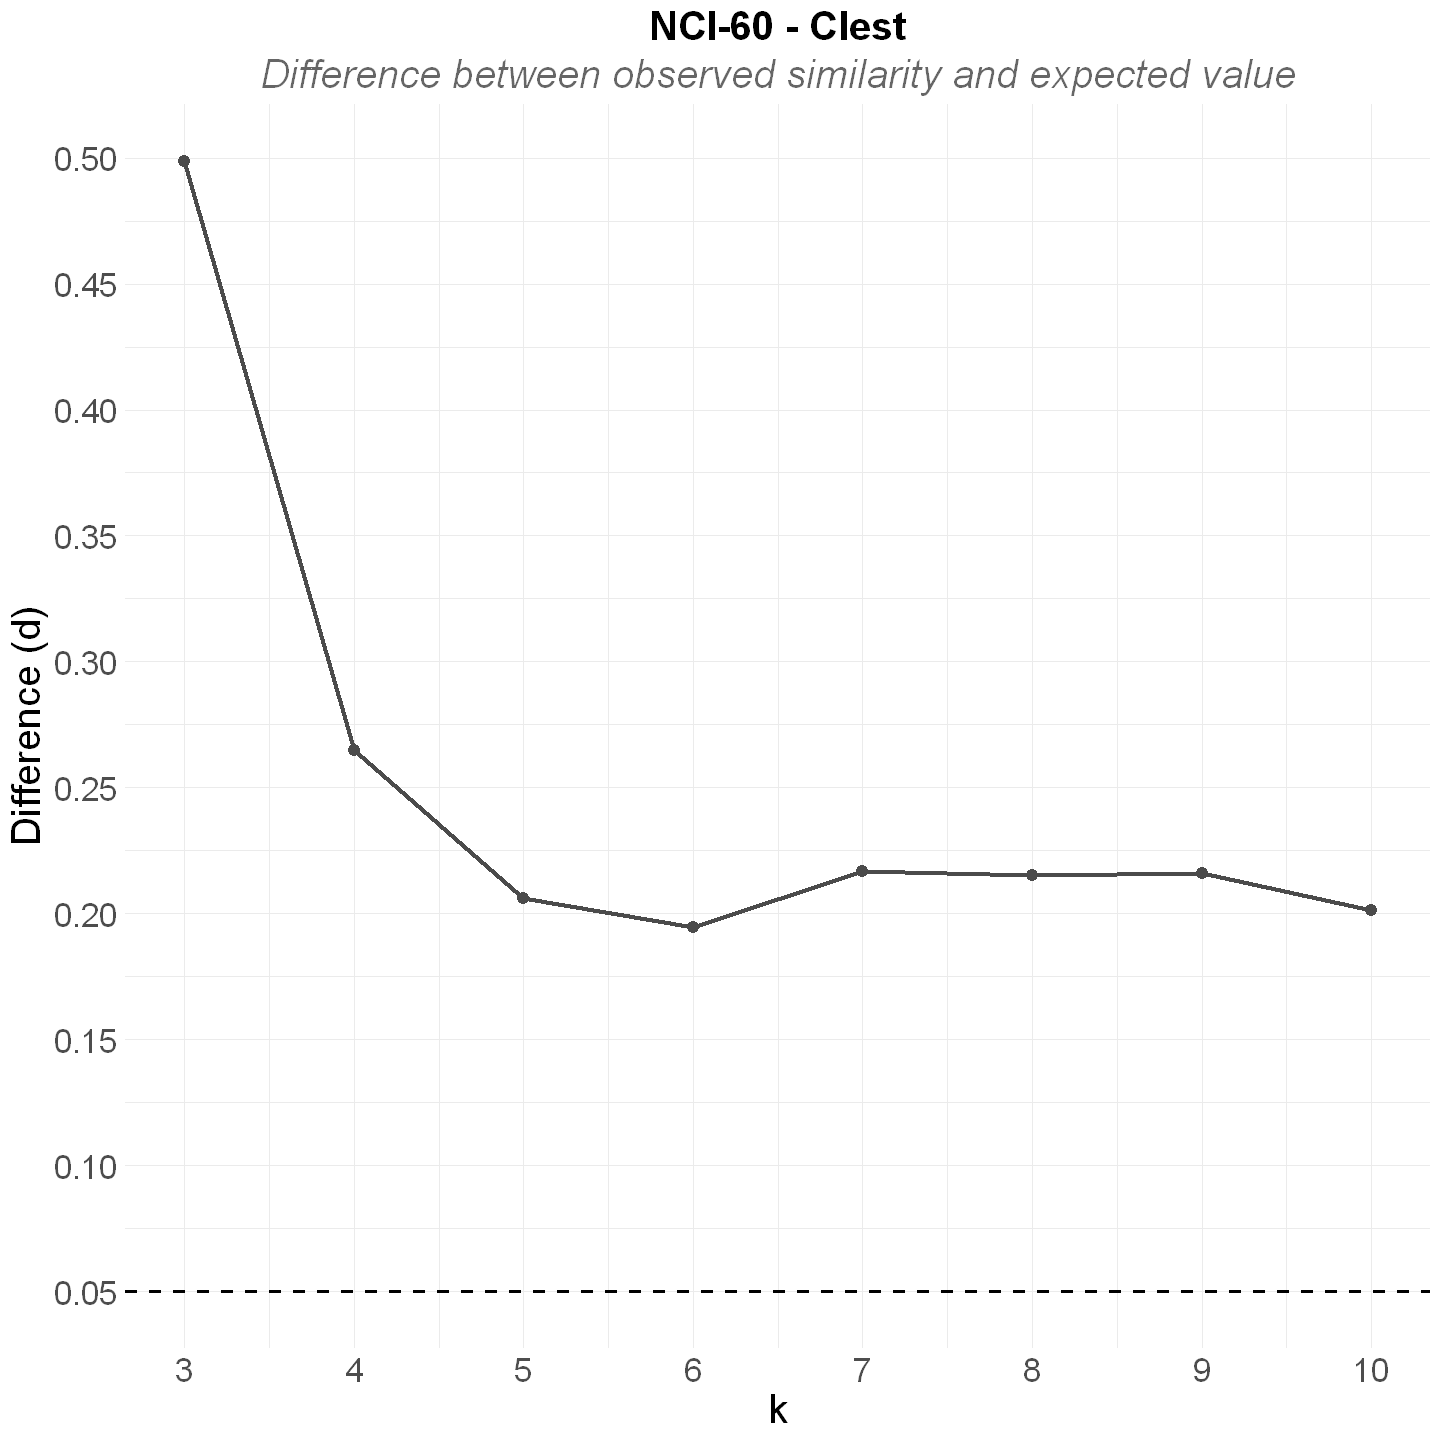

In [46]:
df <- data.frame(K = c(2:10), 
                 Difference = clest_result$d)

ggplot(df, aes(x = K, y = Difference)) +
  geom_line(color = "#4B4B4B", size = 1.2) +
  geom_point(size = 3, color = "#4B4B4B") +
  geom_hline(yintercept = 0.05, linetype = "dashed", color = "black", size = 1) +
  scale_y_continuous(breaks = seq(0, max(df$Difference) + 0.05, by = 0.05)) +
  scale_x_continuous(
    limits = c(3, max(df$K)),
    breaks = seq(3, max(df$K), by = 1)
  ) +
  labs(title = "NCI-60 - Clest",
       subtitle = "Difference between observed similarity and expected value",
       x = "k", 
       y = "Difference (d)") +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 24, face = "bold"),
    plot.subtitle = element_text(hjust = 0.5, size = 24, face = "italic", color = "gray40"),
    legend.position = "right",
    legend.title = element_text(size = 24),
    legend.text = element_text(size = 20),
    axis.title.x = element_text(size = 24),
    axis.title.y = element_text(size = 24),
    axis.text = element_text(size = 20)
  )